In [18]:
from lib import Signal
import matplotlib.pyplot as plt

In [201]:
#Imports TODO: Add a install.py script to check if all dependencies are installed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.io.wavfile as wf
import scipy.signal
from pprint import pprint

class Signal:
    
    def __init__(self, path, name, mode='dev'):
        file = wf.read(path)
        self.Fs = file[0]
        self.s = file[1]
        self.N = self.s.shape[0]
        self.T = self.N/self.Fs
        self.t = np.arange(0,self.T,1/self.Fs)
        self.mode = mode
        self.name = name
    
    def periodogram(self, s, F_samp):
        '''peiodogram sygnału s
        okno - synał będzie przez nie przemnożony w czasie
        F_samp- częstość próbkowania'''
        S = np.fft.rfft(s)# Oblicz transformatę Fouriera sygnału przy pomocy funkcji <tt>rfft</tt>
        S = 20*np.log10(abs(S))
        P =  S*S.conj()# Oblicz moc jako iloczyn unormowanej transformaty i jej sprzężenia zespolonego. 
        P /= F_samp # Unormuj widmo dzieląc przez częstość próbkowania
        P = P.real# Do dalszych operacji wybierz tylko część rzeczywistą mocy. 
        if len(s)%2 ==0: # dokładamy moc z ujemnej części widma 
            P[1:-1] *=2
        else:
            P[1:] *=2
        return P
    
    def plot_signal(self, show = True, invert=False, low=0, high=-1):
        # Show the sound on a plot
        if show: plt.figure(figsize=(20,10))
        if invert: plt.plot(self.s[low:high], self.t[low:high])
        if not invert: 
            plt.plot(self.t[low:high],self.s[low:high])
            plt.xlim(self.t[low], self.t[high])
        if show:
            plt.show()
            
    def plot_fft(self, show = True, invert=True, low=0, high=-1):
        # Show the sound on a plot
        spectrum = lambda s: 20*np.log10(abs(np.fft.rfft(s)/self.Fs))
        df = lambda f: abs(np.fft.rfftfreq(len(self.s), 1/self.Fs) - f)
        f_start = 0
        f_end = -1
        if low != 0:
            f_start = np.where(df(low) == min(df(low)))[0][0]
        if high != -1:
            f_end = np.where(df(high) == min(df(high)))[0][0]
            
        if show: plt.figure(figsize=(20,10))
        if invert:
            #             plt.plot(abs(np.fft.rfft(self.s))[f_start:f_end], np.fft.rfftfreq(len(self.s), 1/self.Fs)[f_start:f_end])
            plt.plot(spectrum(self.s)[f_start:f_end], np.fft.rfftfreq(len(self.s), 1/self.Fs)[f_start:f_end])
            plt.ylim(low, high)
            plt.gca().invert_xaxis()
        if not invert: 
            plt.plot(np.fft.rfftfreq(len(self.s), 1/self.Fs)[f_start:f_end],spectrum(self.s)[f_start:f_end])
            plt.xlim(0,36)
        if show:
            plt.show()
    
    def set_window(self,window = lambda n: np.ones(n)):
        if type(window) == type(lambda t: t):
            self.window = window

        else:
            raise TypeError('Invalid type of window, must be a function. eg. lambda x: np.ones(x)')
    
    def find_cut_off(self, W, ratio=0.0001):
        summed = np.sum(W, axis=1)
        summed /= np.linalg.norm(summed)
        max_val = max(summed)
        summed /= max_val
        summed[summed < ratio] = 0
        return np.where(summed == 0)[0][0]
    
    def calc_spectogram(self, cover, length, t_low=0, t_high=-1):
        # cut up the data into n smaller pieces
    
        step = length - cover*length
        n = np.floor((self.N-length)/step)
        a_minor = np.array(list(map(lambda i: self.s[int(i*step) : int(i*step+length)], range(int(n))))) # This is not fully working
         # setup the array size
        
        while self.N%n != 0: #Find the first integer division
            n -= 1

        l_probe = int(self.N/n)
        t_probe = l_probe/self.Fs
        self.l_probe = l_probe
        if (self.mode == 'dev'): print('Length of probe: {}, {:.3f}s \nNumber of probes: {}'.format(l_probe, t_probe, n))

        #a_minor = self.s.reshape(n, int(self.N/n))
        t_minor = np.arange(0, int(self.N/n)/self.Fs, 1/self.Fs)
        
        #Ok so now we have an array of a cut up signal, we need to window each signal and find the FFT of all trials
        w = self.window(a_minor.shape[1])
        w /= np.linalg.norm(w)
        w_minor = a_minor * w
        spectrum = lambda s: 20*np.log10(abs(np.fft.rfft(s)/self.Fs))
        self.W_minor = spectrum(w_minor).astype('float').T #Switch to periodogram
        #self.W_minor = np.array(list(map(lambda s: self.periodogram(s, self.Fs), w_minor ))).T
        self.F_minor = np.fft.rfftfreq(len(w_minor[0]), 1/self.Fs)
    
    def plot_spectogram(self,
                        length=1024,
                        cover=0.0,
                        show = True,
                        scale = 'manual',
                        ratio = 0.01,
                        t_start=0,
                        t_end=-1,
                        f_start=0,
                        f_end=-1,
                        mode = 'full'):
        
        try:
            if self.W_minor == None or self.F_minor == None:
                pass
        except:
            self.calc_spectogram(cover=0.5, length=1024)
            
        #Finding the boundries
        dt = lambda t: abs(self.t - t)
        t0 = 0
        tmax = -1
        if t_start != 0:
            t_start = np.where(dt(t_start) == min(dt(t_start)))[0][0]
            t0 = np.ceil(t_start/self.l_probe).astype('int')
            
        if t_end != -1:
            t_end = np.where(dt(t_end) == min(dt(t_end)))[0][0]
            tmax = np.ceil(t_end/self.l_probe).astype('int')
        
        df = lambda f: abs(self.F_minor - f)
        if f_start != 0:
            f_start = np.where(df(f_start) == min(df(f_start)))[0][0]
        if f_end != -1:
            f_end = np.where(df(f_end) == min(df(f_end)))[0][0]
        
        print('time ', t_start, t_end)
        print('frequency ', f_start, f_end)
        print('time ow high', t0, tmax)
        print(self.W_minor.shape)
       
            
        if self.mode == 'dev': print(self.W_minor.shape)
            
        if scale == 'auto': cutoff = self.find_cut_off(self.W_minor, ratio)
        if mode == 'full':
            plt.figure(figsize=((20,20)))
            plt.subplot2grid((3, 3), (0, 0), rowspan=2)
            self.plot_fft(show = False, invert=True, low=self.F_minor[f_start], high=self.F_minor[f_end])
        
            plt.subplot2grid((3, 3), (0, 1), colspan=2, rowspan=2)
            plt.title(self.name + ' Spectogram')
            plt.ylabel('Frequencies [Hz]')
            plt.xlabel('Time [s]')
            extent=[ self.t[t_start], self.t[t_end], self.F_minor[f_start], self.F_minor[f_end] ]
            aspect=(self.t[t_end]-self.t[t_start])/(self.F_minor[f_end] - self.F_minor[f_start])


            plt.imshow(self.W_minor[f_start:f_end, t0:tmax], extent = extent, aspect = aspect , origin='lower', cmap="nipy_spectral")
            
            plt.subplot2grid((3, 3), (2, 1), colspan=2)
            self.plot_signal(show = False, low=int(t_start), high=int(t_end))
                        
        if mode == 'plain':
            plt.title(self.name + ' Spectogram')
            plt.ylabel('Frequencies [Hz]')
            plt.xlabel('Time [s]')
            plt.imshow(self.W_minor[f_start:f_end, s:t_end], extent=[ self.t[t_start], self.t[t_end], self.F_minor[f_start], self.F_minor[f_end] ], aspect=(self.t[t_end]-self.t[f_start])/(self.F_minor[f_end] - self.F_minor[f_start]), origin='lower', cmap="hot")
        # plt.colorbar()
        if show:
            plt.show()
        

Length of probe: 525, 0.012s 
Number of probes: 3024.0
time  0 -1
frequency  0 -1
time ow high 0 -1
(513, 3098)
(513, 3098)


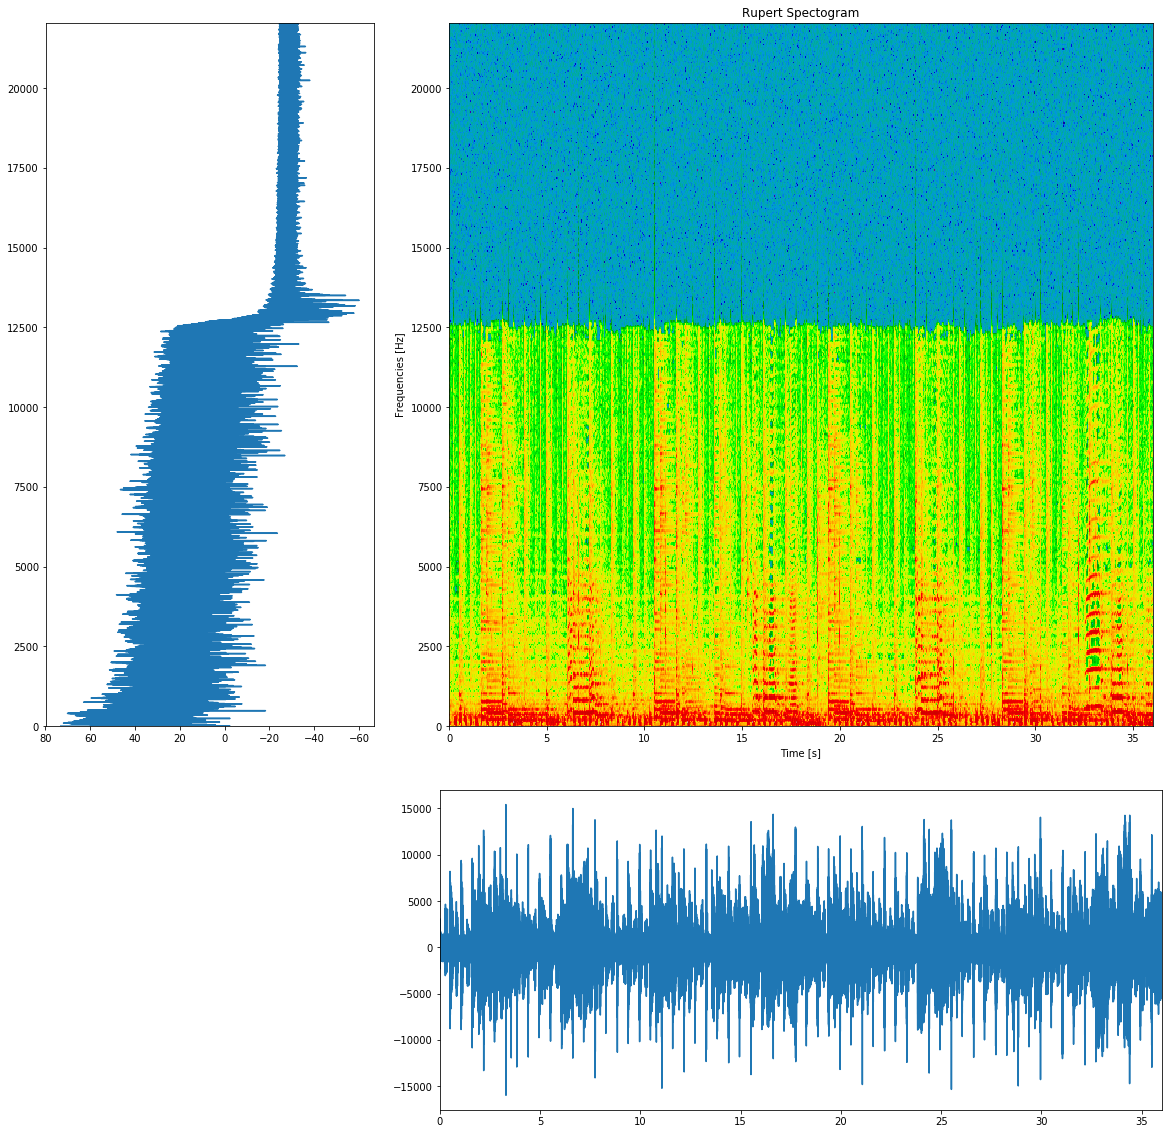

In [206]:
rupert = Signal('./data/candy.wav', 'Rupert')
rupert.set_window(lambda n: scipy.signal.blackman(n))
rupert.plot_spectogram(show=False, cover=0.5, length=10000, t_start=0, t_end=-1, f_start=0,f_end=-1,)

plt.show()

# plt.figure(figsize=((20,40)))

# gs = gridspec.GridSpec(2, 2, width_ratios=[1, 3])

# plt.subplot(gs[1])
# candy = Signal('./data/candy.wav')
# candy.set_window(lambda n: scipy.signal.blackman(n))
# plt.title('Candy Spectogram')
# plt.ylabel('Frequencies [Hz]')
# plt.xlabel('Time [s]')
# candy.plot_spectogram(show=False, N_wsp=30, ratio=0.03)

# plt.show()

In [122]:
2**np.ceil(np.log2(2930)) - 2930

1166.0